In [1]:
import math
import time
import pickle
import pandas as pd
import numpy as np

In [2]:
import torch
import sklearn

In [3]:
from pyqpanda import *

In [4]:
%matplotlib inline

# 1. Prepare Dadaset

In [5]:
# https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data

In [6]:
train_path = './../data/DailyDelhiClimateTrain.csv'
test_path = './../data/DailyDelhiClimateTest.csv'

In [7]:
cols = [1,2,3,4]

train = pd.read_csv(train_path, usecols=cols, engine="python")
test = pd.read_csv(test_path, usecols=cols, engine="python")

In [8]:
print(f'len(train)={len(train)}')
print(f'len(test)={len(test)}')

len(train)=1462
len(test)=114


## 1.1 Outlier Detection

### 1.1.1 outlier detection for train

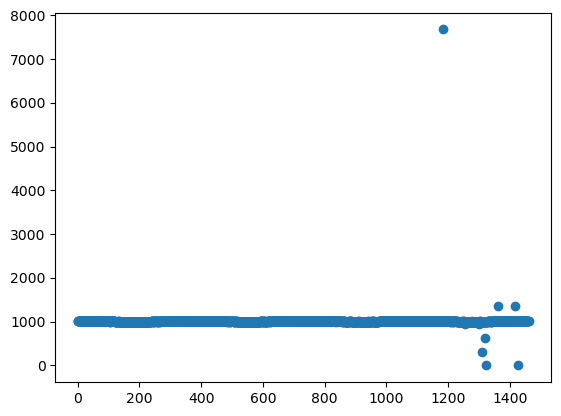

In [9]:
plt.scatter(range(len(train)), train["meanpressure"])

### - remove outliers 

In [10]:
unnormal_num = 0
for i in range(len(train)):
    mp = train.iloc[i][3]
    if mp > 1200 or mp < 950:
        unnormal_num += 1
        train.iloc[i][3] = train.iloc[i + 1][3]
print(f'remove outliers num: {unnormal_num}')

remove outliers num: 9


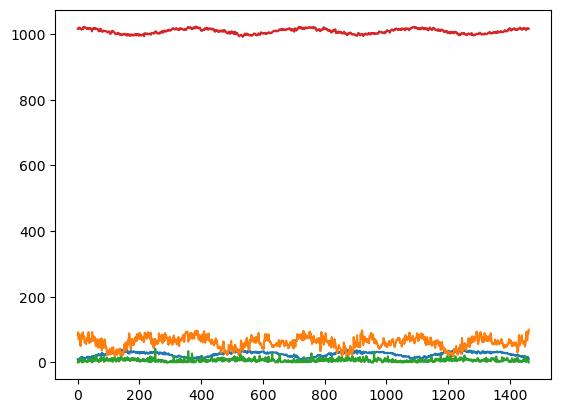

In [11]:
plt.plot(train)

In [12]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
meantemp,1462.0,25.495521,7.348103,6.000000,18.857143,27.714286,31.305804,38.714286
humidity,1462.0,60.771702,16.769652,13.428571,50.375000,62.625000,72.218750,100.000000
wind_speed,1462.0,6.802209,4.561602,0.000000,3.475000,6.221667,9.238235,42.220000
meanpressure,1462.0,1008.247674,7.437992,991.375000,1001.625000,1008.563492,1014.875000,1023.000000


In [13]:
train[0:1]

,meantemp,humidity,wind_speed,meanpressure
0,10.0,84.5,0.0,1015.666667


### 1.1.2 outlier detection for test

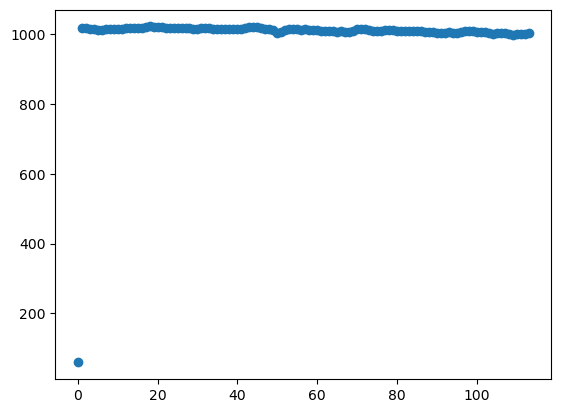

In [14]:
plt.scatter(range(len(test)), test["meanpressure"])

### - remove outliers 

In [15]:
test.iloc[0][3] = test.iloc[1][3]

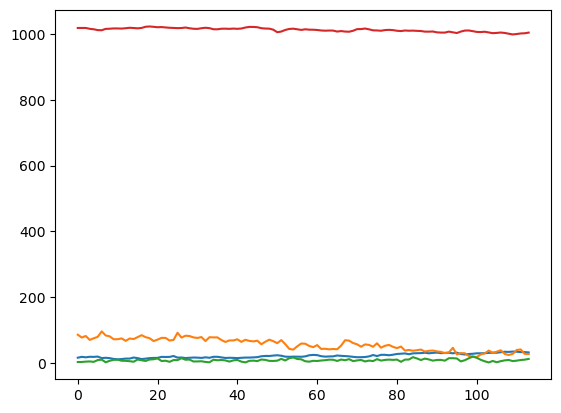

In [16]:
plt.plot(test)

## 1.2 Transfer data to LSTM representation

In [17]:
from sklearn.preprocessing import StandardScaler

In [18]:
def data_process(data, window_size, predict_size):
    scaler = StandardScaler()
    data = scaler.fit_transform(np.array(data).reshape(-1, 1))
    
    data_in = []
    data_out = []
    
    for i in range(data.shape[0] - window_size - predict_size):
        data_in.append(data[i:i + window_size].reshape(1, window_size)[0])
        data_out.append(data[i + window_size:i + window_size + predict_size].reshape(1, predict_size)[0])
        
    data_in = np.array(data_in).reshape(-1, window_size)
    data_out = np.array(data_out).reshape(-1, predict_size)
    
    data_process = {'datain': data_in, 'dataout': data_out}
    
    return data_process, scaler

## 1.3 prepare train/test dataset

In [19]:
features_size = 4
window_size = features_size * 3 # features num * time steps
predict_size = features_size # features

In [20]:
train_processed, train_scaler = data_process(train, window_size, predict_size)
X_train, y_train = train_processed['datain'], train_processed['dataout']

test_processed, test_scaler = data_process(test, window_size, predict_size)
X_test, y_test = test_processed['datain'], test_processed['dataout']

In [21]:
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))

y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

### - data loader

In [22]:
import torch.utils.data as Data

train_data = Data.TensorDataset(X_train, y_train)
test_data = Data.TensorDataset(X_test, y_test)

In [23]:
print(f'size of train_data: {len(train_data)}')
print(f'size of test_data: {len(test_data)}')

size of train_data: 5832
size of test_data: 440


In [24]:
train_data[0]

(tensor([-0.6262, -0.4504, -0.6498,  1.7473, -0.6323, -0.4327, -0.6428,  1.7523,
         -0.6329, -0.4445, -0.6389,  1.7543]),
 tensor([-0.6293, -0.4814, -0.6469,  1.7508]))

In [25]:
test_data[0]

(tensor([-0.6067, -0.4426, -0.6376,  1.7437, -0.6006, -0.4629, -0.6372,  1.7437,
         -0.6039, -0.4520, -0.6346,  1.7438]),
 tensor([-0.6001, -0.4797, -0.6333,  1.7377]))

# 2. Quantum Enhanced LSTM

## 2.1 initiate quantum environment

In [26]:
class InitQMachine:
    def __init__(self, qubitsCount, cbitsCount = 0, machineType = QMachineType.CPU):
        self.machine = init_quantum_machine(machineType)
        
        self.qubits = self.machine.qAlloc_many(qubitsCount)
        self.cbits = self.machine.cAlloc_many(cbitsCount)
        
        print(f'Init Quantum Machine with qubits:[{qubitsCount}] / cbits:[{cbitsCount}] Successfully')
    
    def __del__(self):
        destroy_quantum_machine(self.machine)

In [27]:
# maximum qubits size
ctx = InitQMachine(5)

Init Quantum Machine with qubits:[5] / cbits:[0] Successfully


## 2.2 Quantum Layer

### - Tool Functions

In [28]:
def draw(prog, filename=''):
    dir_path = './images/'
    
    if filename != '':
        draw_qprog(prog, 'pic', filename=f'{dir_path}{filename}')

### 2.2.1 Quantum Layer Base

In [29]:
import torch.nn as nn
from torch import Tensor
from torch.nn import Parameter

In [30]:
class QuantumLayerBase(nn.Module):
    def __init__(self, input_size, output_size, *, n_qubits, n_layers = 1, ctx = None):
        super(QuantumLayerBase, self).__init__()
        
        self.data = None # need to input during forward
    
        self.input_size = input_size
        self.output_size = output_size # hidden size, not n_qubits
        
        # quantum infos
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        
        self.ctx = ctx
        self.qubits = ctx.qubits
        self.machine = ctx.machine
        
        # convert quantum input/output to match classical computation
        self.qin = nn.Linear(self.input_size, self.n_qubits)
        self.qout = nn.Linear(self.n_qubits, self.output_size)
        
    @property
    def circuit(self):
        raise NotImplementedError('Should init circuit')

In [31]:
def measure(self):
    HamiZ = [ PauliOperator({f'Z{i}': 1}) for i in range(len(self.qubits)) ]
    res = [ eval(qop(self.circuit, Hami, self.machine, self.qubits))[0,0] for Hami in HamiZ ]
    
    return Parameter(Tensor(res[:self.n_qubits]))

QuantumLayerBase.measure = measure

In [32]:
def forward(self, inputs):
    y_t = self.qin(Parameter(inputs))
    self.data = y_t[0]
    
    return self.qout(self.measure())

QuantumLayerBase.forward = forward

### 2.2.2 Quantum Layer Design

In [33]:
dropout_lock = True

In [35]:
class QuantumLayer(QuantumLayerBase):
    def __init__(self, input_size, output_size, *, n_qubits, degree = 1, n_layers = 1, ctx = None, dropout_rate = 0):
        super(QuantumLayer, self).__init__(input_size, output_size, 
                                         n_qubits = n_qubits, n_layers = n_layers, ctx = ctx)
        
        self.degree = degree
        self.dropout_rate = dropout_rate
        self.angles = Parameter(torch.rand(n_layers + 1, degree, self.n_qubits))
        
    @property
    def qparameters_size(self):
        return self.angles.flatten().size()[0]
        
    @property
    def circuit(self):
        if self.data == None:
            raise ValueError('Need to feed a input data!')
        
        n = self.n_qubits
        q = self.qubits
        x = self.data
        p = self.angles
        degree = self.degree
        
        # quantum gates - must use small case!
        identity = VariationalQuantumGate_I
        h = VariationalQuantumGate_H
        XGate = VariationalQuantumGate_X
        ry = VariationalQuantumGate_RY
        cz = VariationalQuantumGate_CZ
        u = [
            None,
            VariationalQuantumGate_U1,
            VariationalQuantumGate_U2,
            VariationalQuantumGate_U3
        ]
        
        # init variational quantum circuit
        vqc = VariationalQuantumCircuit()

        # in order to use each qubits => when n_qubits < len(ctx.qubits)
        [ vqc.insert(identity(q[i])) for i in range(len(q)) ]
        
        [ vqc.insert( h(q[i]) ) for i in range(n) ]
        [ vqc.insert( ry(q[i], var(x[i] * torch.pi / 2)) ) for i in range(n) ]
        
    
        for i in range(n):
            vqc.insert( u[degree](q[i], *[ var(p[0][d][i]) for d in range(degree) ]) )
            if dropout_lock and np.random.rand() <= self.dropout_rate:
                vqc.insert( XGate(q[i]) )
        
        for layer in range(self.n_layers):
            for i in range(n - 1):
                if (not dropout_lock) or np.random.rand() > 0.0005:
                    vqc.insert(cz(q[i], q[i + 1]))
            if (not dropout_lock) or np.random.rand() > 0.0005:
                vqc.insert(cz(q[n - 1], q[0]))
            
            for i in range(n):
                vqc.insert( u[degree](q[i], *[ var(p[layer + 1][d][i]) for d in range(degree) ]) )
                if dropout_lock and np.random.rand() <= self.dropout_rate:
                    vqc.insert( XGate(q[i]) )
        
        return vqc

## 2.3 Quantum-LSTM

In [36]:
class QLSTMBase(nn.Module):
    def __init__(self, input_size, hidden_size, *, ctx, dropout_rate=0):
        super().__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.ctx = ctx
        self.dropout_rate = dropout_rate
        
    @property
    def qparameters_size(self):
        num = 0
        for attr in dir(self):
            if attr.endswith('_circuit'):
                num += getattr(self, attr).qparameters_size
        return num

In [37]:
def forward(self, inputs, init_states = None):
    sequence_size, batch_size, _ = inputs.size()
    hidden_sequence = []
    
    if init_states == None:
        h_t, c_t = (
            torch.zeros(1, batch_size, self.hidden_size).to(inputs.device),
            torch.zeros(1, batch_size, self.hidden_size).to(inputs.device),
        )
    else:
        h_t, c_t = init_states
    
    return hidden_sequence, (h_t, c_t)

QLSTMBase.forward = forward

### 2.3.1 classical Quantum-LSTM

In [38]:
class QLSTM(QLSTMBase):
    def __init__(self, input_size, hidden_size, *, ctx, dropout_rate=0):
        super().__init__(input_size, hidden_size, ctx = ctx, dropout_rate = dropout_rate)
        
        # Parameters: angles
        #  => Q * (n + 1) * degree
        
        # gates names:  qubits  layers  degree
        # input gate:     5       2       3
        # forget gate:    5       2       3
        # candidate:      5       2       3
        # output gate:    5       2       3
        
        # input gates
        self.input_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                        n_qubits = 5, n_layers = 2, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 45
        # forget gates
        self.forget_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                         n_qubits = 5, n_layers = 2, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 45
        # candidate
        self.candidate_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                       n_qubits = 5, n_layers = 2, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 45
        # output gates
        self.output_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                         n_qubits = 5, n_layers = 2, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 45
        
    def forward(self, inputs, init_states = None):
        hidden_sequence, (h_t, c_t) = super(QLSTM, self).forward(inputs, init_states)

        for t in range(inputs.size()[0]):
            x_t = inputs[t, :, :]
            v_t = torch.cat((h_t[0], x_t), dim = 1)

            # input gates
            i_t = torch.sigmoid(self.input_circuit(v_t))
            # forget gates
            f_t = torch.sigmoid(self.forget_circuit(v_t))
            # candidate for cell state update
            g_t = torch.tanh(self.candidate_circuit(v_t))
            c_t = (f_t * c_t) + (i_t * g_t)

            # output gates
            o_t = torch.sigmoid(self.output_circuit(v_t))
            # update output ht
            h_t = o_t * (torch.tanh(c_t))

            hidden_sequence.append(h_t)

        # reshape hidden_seq p/ retornar
        #
        # [tensor([[[0.0444, ...]]] => tensor([[[0.0444, ...]]]
        # 
        hidden_sequence = torch.cat(hidden_sequence, dim = 0)

        return hidden_sequence, (h_t, c_t)

### 2.3.2 adjusted classical QLSTM

In [39]:
class AdjustedQLSTM(QLSTMBase):
    def __init__(self, input_size, hidden_size, *, ctx, dropout_rate = 0):
        super().__init__(input_size, hidden_size, ctx = ctx, dropout_rate = dropout_rate)
        
        # gates names:  qubits  layers  degree
        # input gate:     4       2       3
        # forget gate:    5       2       3
        # candidate:      4       1       3
        # output gate:    3       2       2
        
        # input gates
        self.input_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                        n_qubits = 4, n_layers = 2, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 36
        # forget gates
        self.forget_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                         n_qubits = 5, n_layers = 2, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 45
        # candidate
        self.candidate_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                       n_qubits = 4, n_layers = 1, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 24
        # output gates
        self.output_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                         n_qubits = 3, n_layers = 2, degree = 2, ctx = ctx, dropout_rate = dropout_rate) # 18
        
    def forward(self, inputs, init_states = None):
        hidden_sequence, (h_t, c_t) = super(AdjustedQLSTM, self).forward(inputs, init_states)

        for t in range(inputs.size()[0]):
            x_t = inputs[t, :, :]
            v_t = torch.cat((h_t[0], x_t), dim = 1)

            # input gates
            i_t = torch.sigmoid(self.input_circuit(v_t))
            # forget gates
            f_t = torch.sigmoid(self.forget_circuit(v_t))
            # candidate for cell state update
            g_t = torch.tanh(self.candidate_circuit(v_t))
            c_t = (f_t * c_t) + (i_t * g_t)

            # output gates
            o_t = torch.sigmoid(self.output_circuit(v_t))
            # update output ht
            h_t = o_t * (torch.tanh(c_t))

            hidden_sequence.append(h_t)

        hidden_sequence = torch.cat(hidden_sequence, dim = 0)

        return hidden_sequence, (h_t, c_t)

### 2.3.3 peephole QLSTM

In [40]:
class PeepholeQLSTM(QLSTMBase):
    def __init__(self, input_size, hidden_size, *, ctx, dropout_rate = 0):
        super().__init__(input_size, hidden_size, ctx = ctx, dropout_rate = dropout_rate)
        
        # gates names:  qubits  layers  degree
        # input gate:     4       2       3
        # forget gate:    5       2       3
        # candidate:      4       1       3
        # output gate:    3       2       2
        
        # input gates
        self.input_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                        n_qubits = 4, n_layers = 2, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 36
        # forget gates
        self.forget_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                         n_qubits = 5, n_layers = 2, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 45
        # candidate
        self.candidate_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                       n_qubits = 4, n_layers = 1, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 24
        # output gates
        self.output_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                         n_qubits = 3, n_layers = 2, degree = 2, ctx = ctx, dropout_rate = dropout_rate) # 18
        
    def forward(self, inputs, init_states = None):
        hidden_sequence, (h_t, c_t) = super(PeepholeQLSTM, self).forward(inputs, init_states)

        for t in range(inputs.size()[0]):
            x_t = inputs[t, :, :]
            v_t = torch.cat((c_t[0], x_t), dim = 1)
            
            # input gates
            i_t = torch.sigmoid(self.input_circuit(v_t))
            # forget gates
            f_t = torch.sigmoid(self.forget_circuit(v_t))
            # candidate for cell state update
            g_t = torch.tanh(self.candidate_circuit(v_t))
            c_t = (f_t * c_t) + (i_t * g_t)
            
            # output gates
            o_t = torch.sigmoid(self.output_circuit(v_t))
            # update output ht
            h_t = o_t * (torch.tanh(c_t))

            hidden_sequence.append(h_t)

        hidden_sequence = torch.cat(hidden_sequence, dim = 0)

        return hidden_sequence, (h_t, c_t)

### 2.3.4 Coupled Input and Forget gates QLSTM

In [41]:
class CIFGQLSTM(QLSTMBase):
    def __init__(self, input_size, hidden_size, *, ctx, dropout_rate = 0):
        super().__init__(input_size, hidden_size, ctx = ctx, dropout_rate = dropout_rate)
        
        # gates names:  qubits  layers  degree
        # coupled IF:     5       2       3
        # candidate:      4       2       3
        # output gate:    3       2       2
        
        # Coupled Input and Forget gate
        self.coupled_IF_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                         n_qubits = 5, n_layers = 2, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 30
        # candidate for cell state update
        self.candidate_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                       n_qubits = 4, n_layers = 2, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 24
        # output gates
        self.output_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                         n_qubits = 3, n_layers = 2, degree = 2, ctx = ctx, dropout_rate = dropout_rate) # 12
        
    def forward(self, inputs, init_states = None):
        hidden_sequence, (h_t, c_t) = super(CIFGQLSTM, self).forward(inputs, init_states)

        for t in range(inputs.size()[0]):
            x_t = inputs[t, :, :]
            v_t = torch.cat((h_t[0], x_t), dim = 1)
            
            # coupled input and forget gate
            f_t = torch.sigmoid(self.coupled_IF_circuit(v_t))
            # candidate for cell state update
            g_t = torch.tanh(self.candidate_circuit(v_t))
            c_t = (f_t * c_t) + ((1 - f_t) * g_t)
            
            # output gates
            o_t = torch.sigmoid(self.output_circuit(v_t))
            # update output ht
            h_t = o_t * (torch.tanh(c_t))

            hidden_sequence.append(h_t)

        hidden_sequence = torch.cat(hidden_sequence, dim = 0)

        return hidden_sequence, (h_t, c_t)

### 2.3.5 Recurrent Gate Units - QGRU

In [42]:
class QGRU(QLSTMBase):
    def __init__(self, input_size, hidden_size, *, ctx, dropout_rate = 0):
        super().__init__(input_size, hidden_size, ctx = ctx, dropout_rate = dropout_rate)
        
        # gates names:  qubits  layers  degree
        # update gate:     5       1       3
        # candidate:       4       1       3
        # reset gate:      3       1       2
        
        # update gates
        self.update_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                         n_qubits = 5, n_layers = 1, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 45
        # candidate for hidden state update
        self.candidate_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                       n_qubits = 4, n_layers = 1, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 36
        # reset gates
        self.reset_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                         n_qubits = 3, n_layers = 1, degree = 2, ctx = ctx, dropout_rate = dropout_rate) # 18
        
    def forward(self, inputs, init_states = None):
        hidden_sequence, (h_t, c_t) = super(QGRU, self).forward(inputs, init_states)

        for t in range(inputs.size()[0]):
            x_t = inputs[t, :, :]
            v_t = torch.cat((h_t[0], x_t), dim = 1)
            
            # update gates
            z_t = torch.sigmoid(self.update_circuit(v_t))
            # reset gates
            r_t = torch.sigmoid(self.reset_circuit(v_t))
        
            v_hat_t = torch.cat(((r_t * h_t)[0], x_t), dim = 1)
            # candidate for hidden state update
            g_t = torch.tanh(self.candidate_circuit(v_hat_t))
            h_t = (z_t * g_t) + (1 - z_t) * h_t 

            hidden_sequence.append(h_t)

        hidden_sequence = torch.cat(hidden_sequence, dim = 0)

        return hidden_sequence, (h_t, c_t)

### - QLSTMs Map

In [43]:
QLSTMMap = {
    'classical': ('QLSTM', QLSTM),
    'adjusted': ('QLSTM(adjusted)', AdjustedQLSTM),
    'peephole': ('peephole QLSTM', PeepholeQLSTM),
    'CIFG': ('CIFG-QLSTM', CIFGQLSTM),
    'GRU': ('QGRU', QGRU)
}

## 2.4 Stacked QLSTM

In [44]:
from collections import OrderedDict

class StackedQLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, *, num_layers = 1, ctx = None, mode = 'classical', dropout_rate = 0):
        super().__init__()
        
        label, qlstm = QLSTMMap.get(mode)
        self.qlstms = nn.Sequential(OrderedDict([
            (f'{label} {i + 1}', qlstm(input_size if i == 0 else hidden_size , hidden_size, ctx = ctx, dropout_rate = dropout_rate)) 
                for i in range(num_layers)
        ]))

    def forward(self, inputs, parameters = None):
        outputs = None
        
        for i, qlstm in enumerate(self.qlstms):
            if i != 0:
                inputs = outputs
            
            outputs, parameters = qlstm(inputs, parameters)
        
        return outputs, parameters

# 3. Quantum Model and Train

In [45]:
class QModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_output, *, num_layers = 1, ctx = None, mode = 'classical', dropout_rate = 0):
        super(QModel, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.mode = mode
        
        self.qlstm = StackedQLSTM(input_size, hidden_size, 
                                  num_layers = num_layers, ctx = ctx, mode = mode, dropout_rate = dropout_rate)
        self.predict = nn.Linear(hidden_size, num_output)

    def forward(self, x):
        x = x.unsqueeze(0)
        
        # sequence lenth , batch_size, features length
        # 
        h0 = torch.zeros(1, x.size(1), self.hidden_size)
        c0 = torch.zeros(1, x.size(1), self.hidden_size)
        
        out, _ = self.qlstm(x, (h0, c0))
        out = self.predict(out[0])
        
        return out

## 3.1 train QModel

In [46]:
from torch.utils.data import RandomSampler

def train_model(model, datas, batch_size, *, loss_func, optimizer, epoch = 50, early_stop = False):
    losses = []
    sampler = RandomSampler(datas, num_samples = batch_size)
    
    last_loss = 0.0
    for step in range(epoch):
        train_loss = 0.0
        
        for index in sampler:
            batch_x, batch_y = datas[index][0], datas[index][1]
            b_x = batch_x.unsqueeze(0)
            b_y = batch_y.unsqueeze(0)
            
            output = model(b_x)

            loss = loss_func(output, b_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        loss = train_loss / batch_size
        if early_stop and loss < 0.0005:
            break
            
        last_loss = loss
        
        print(f'Epoch {step + 1}/{epoch}: Loss: {loss}')
        losses.append(loss)
    
    return losses

## 3.2 Evaluate Model

In [47]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

def MAE_naive(actuals, predicteds):
    n = len(actuals)
    err = 0.0
    
    for i in range(1, n):
        err += np.abs(actuals[i] - actuals[i - 1])
    return err / (n - 1)

def calculate_accuarcy(model, X_test, y_test, scaler=test_scaler):
    n = len(X_test)
    
    actuals = []
    predicteds = []
    
    for i in range(0, n, predict_size):
        actual = scaler.inverse_transform(y_test[i:i+1].data)
        actuals.append(np.array(actual[0]))
        predicted = scaler.inverse_transform(model(X_test[i:i+1]).data)
        predicteds.append(np.array(predicted[0]))
    
    actuals = np.array(actuals)
    predicteds = np.array(predicteds)
    
    mae = mean_absolute_error(actuals, predicteds)
    mase = mae / MAE_naive(actuals.flatten(), predicteds.flatten())
    mape = mean_absolute_percentage_error(actuals, predicteds)
    mse = mean_squared_error(actuals, predicteds)
    rmse = mse ** 0.5
    
    return np.array([(1 - mase) * 100, rmse, mse, mae, mape])

## 3.3 Train Model

In [48]:
features_size = 4
window_size = features_size * 3 # 
predict_size = features_size # features

input_size = window_size
num_output = predict_size

hidden_size = 32
num_layers = 2

In [49]:
# learning rate:
# classical: 0.0035
# adjusted: 0.0028
# peephole: 0.0027
# CIFG: 0.004
# GRU: 0.0035

In [51]:
epoch = 3
acc, rmse, mse, mae, mape = 0, 0, 0, 0, 0
for i in range(epoch):
    print(f'epoch: {i+1}')
    dropout_lock = True
    qmodel = QModel(input_size, hidden_size, num_output, 
                    num_layers = num_layers, ctx = ctx, mode='classical', dropout_rate = 0.0001)
    optimizer = torch.optim.Adam(qmodel.parameters(), lr = 0.0035)
    loss_func = nn.MSELoss()

    start = time.time()
    losses = train_model(qmodel, train_data, batch_size=20,          
                   loss_func = loss_func, optimizer = optimizer, epoch = 200, early_stop=True)
    end = time.time()

    print(f'time costs: {end - start}')

    dropout_lock = False
    results = calculate_accuarcy(qmodel, X_test, y_test)
    acc += results[0]
    rmse += results[1]
    mse += results[2]
    mae += results[3]
    mape += results[4]

    print(results)

print('mean acc: ', acc / epoch)
print('mean rmse: ', rmse / epoch)
print('mean mse: ', mse / epoch)
print('mean mae: ', mae / epoch)
print('mean mape: ', mape / epoch)

epoch: 1
Epoch 1/200: Loss: 1.0476982086896895
Epoch 2/200: Loss: 0.9697488397359848
Epoch 3/200: Loss: 0.9311165124177933
Epoch 4/200: Loss: 0.8702069699764252
Epoch 5/200: Loss: 0.7693144053220748
Epoch 6/200: Loss: 0.6362940773367882
Epoch 7/200: Loss: 0.532560333609581
Epoch 8/200: Loss: 0.42728370651602743
Epoch 9/200: Loss: 0.29836548343300817
Epoch 10/200: Loss: 0.26227055601775645
Epoch 11/200: Loss: 0.11513915359973907
Epoch 12/200: Loss: 0.16650039586238563
Epoch 13/200: Loss: 0.04935410527978092
Epoch 14/200: Loss: 0.02991843681957107
Epoch 15/200: Loss: 0.010769009790965355
Epoch 16/200: Loss: 0.00821544439313584
Epoch 17/200: Loss: 0.0034071387111907826
Epoch 18/200: Loss: 0.0015319264475692762
Epoch 19/200: Loss: 0.003223988249374088
Epoch 20/200: Loss: 0.005326147426603711
Epoch 21/200: Loss: 0.0006155448871140834
Epoch 22/200: Loss: 0.0008036624248234147
Epoch 23/200: Loss: 0.0005157845585927135
time costs: 226.76509308815002
[98.88828221  7.21298374 52.02713441  5.7625

In [49]:
# bit flip: 0.0001:
# mean acc:  98.75639817507881
# mean rmse:  8.736725688299117
# mean mse:  76.42189093996389
# mean mae:  6.446129444696279
# mean mape:  0.3312014771291267

In [52]:
epoch = 3
acc, rmse, mse, mae, mape = 0, 0, 0, 0, 0
for i in range(epoch):
    print(f'epoch: {i+1}')
    dropout_lock = True
    qmodel = QModel(input_size, hidden_size, num_output, 
                    num_layers = num_layers, ctx = ctx, mode='classical', dropout_rate = 0.001)
    optimizer = torch.optim.Adam(qmodel.parameters(), lr = 0.0035)
    loss_func = nn.MSELoss()

    start = time.time()
    losses = train_model(qmodel, train_data, batch_size=20,          
                   loss_func = loss_func, optimizer = optimizer, epoch = 300, early_stop=True)
    end = time.time()

    print(f'time costs: {end - start}')

    dropout_lock = False
    results = calculate_accuarcy(qmodel, X_test, y_test)
    acc += results[0]
    rmse += results[1]
    mse += results[2]
    mae += results[3]
    mape += results[4]

    print(results)

print('mean acc: ', acc / epoch)
print('mean rmse: ', rmse / epoch)
print('mean mse: ', mse / epoch)
print('mean mae: ', mae / epoch)
print('mean mape: ', mape / epoch)

epoch: 1
Epoch 1/300: Loss: 1.0096623033285141
Epoch 2/300: Loss: 0.9821939408779145
Epoch 3/300: Loss: 0.9830579936504364
Epoch 4/300: Loss: 0.8932032704353332
Epoch 5/300: Loss: 0.8714031368494034
Epoch 6/300: Loss: 0.7778430312871933
Epoch 7/300: Loss: 0.6594045236706734
Epoch 8/300: Loss: 0.5720617234706878
Epoch 9/300: Loss: 0.42309911698102953
Epoch 10/300: Loss: 0.3651998743414879
Epoch 11/300: Loss: 0.3746711866930127
Epoch 12/300: Loss: 0.2969527860172093
Epoch 13/300: Loss: 0.33524756962433455
Epoch 14/300: Loss: 0.421839389577508
Epoch 15/300: Loss: 0.18198004667647183
Epoch 16/300: Loss: 0.2085414385655895
Epoch 17/300: Loss: 0.23563653993769548
Epoch 18/300: Loss: 0.12010707149092922
Epoch 19/300: Loss: 0.26887655221507883
Epoch 20/300: Loss: 0.2190547477453947
Epoch 21/300: Loss: 0.18974971417337655
Epoch 22/300: Loss: 0.16962804588256403
Epoch 23/300: Loss: 0.1424203368340386
Epoch 24/300: Loss: 0.1249284159304807
Epoch 25/300: Loss: 0.06925685014284681
Epoch 26/300: Los

Epoch 200/300: Loss: 0.004505758854065789
Epoch 201/300: Loss: 0.039723415381740776
Epoch 202/300: Loss: 0.00372728802904021
Epoch 203/300: Loss: 0.0040504570650227835
Epoch 204/300: Loss: 0.01337880639184732
Epoch 205/300: Loss: 0.006353749750269344
Epoch 206/300: Loss: 0.026827901993237903
Epoch 207/300: Loss: 0.0019025022054847795
Epoch 208/300: Loss: 0.0030511574863339775
Epoch 209/300: Loss: 0.0007967213645315496
Epoch 210/300: Loss: 0.006162478691112483
Epoch 211/300: Loss: 0.0029946798757009676
Epoch 212/300: Loss: 0.021070772195525934
Epoch 213/300: Loss: 0.0033719539613230156
Epoch 214/300: Loss: 0.0048376223036029845
Epoch 215/300: Loss: 0.00317844183264242
Epoch 216/300: Loss: 0.0011382036507711745
Epoch 217/300: Loss: 0.00178329673508415
Epoch 218/300: Loss: 0.0014874033161504485
Epoch 219/300: Loss: 0.0007165086291934131
Epoch 220/300: Loss: 0.014344140585308196
Epoch 221/300: Loss: 0.0145901938303723
Epoch 222/300: Loss: 0.00572970359280589
Epoch 223/300: Loss: 0.00364756

Epoch 47/300: Loss: 0.01641195154224988
Epoch 48/300: Loss: 0.003832045590024791
Epoch 49/300: Loss: 0.10883516663379851
Epoch 50/300: Loss: 0.012881488939456176
Epoch 51/300: Loss: 0.05134085992758628
Epoch 52/300: Loss: 0.002315609952347586
Epoch 53/300: Loss: 0.000536340387770906
Epoch 54/300: Loss: 0.0005938334623351693
Epoch 55/300: Loss: 0.0015721538540674374
Epoch 56/300: Loss: 0.0017953574930288595
Epoch 57/300: Loss: 0.01967794140728074
Epoch 58/300: Loss: 0.002824987148414948
Epoch 59/300: Loss: 0.0008518139376974432
Epoch 60/300: Loss: 0.0017648606304646818
Epoch 61/300: Loss: 0.0024846599480952136
Epoch 62/300: Loss: 0.0011845706110761966
time costs: 571.7492303848267
[98.62855226  8.71855309 76.01316796  7.10881048  0.26125433]
mean acc:  97.56958841257223
mean rmse:  15.755433805347323
mean mse:  333.0448006225899
mean mae:  12.59788091533413
mean mape:  0.4729227421623144


In [54]:
# mean acc:  97.56958841257223
# mean rmse:  15.755433805347323
# mean mse:  333.0448006225899
# mean mae:  12.59788091533413
# mean mape:  0.4729227421623144

In [53]:
epoch = 3
acc, rmse, mse, mae, mape = 0, 0, 0, 0, 0
for i in range(epoch):
    print(f'epoch: {i+1}')
    dropout_lock = True
    qmodel = QModel(input_size, hidden_size, num_output, 
                    num_layers = num_layers, ctx = ctx, mode='classical', dropout_rate = 0.01)
    optimizer = torch.optim.Adam(qmodel.parameters(), lr = 0.01)
    loss_func = nn.MSELoss()

    start = time.time()
    losses = train_model(qmodel, train_data, batch_size=20,          
                   loss_func = loss_func, optimizer = optimizer, epoch = 300, early_stop=True)
    end = time.time()

    print(f'time costs: {end - start}')

    dropout_lock = False
    results = calculate_accuarcy(qmodel, X_test, y_test)
    acc += results[0]
    rmse += results[1]
    mse += results[2]
    mae += results[3]
    mape += results[4]

    print(results)

print('mean acc: ', acc / epoch)
print('mean rmse: ', rmse / epoch)
print('mean mse: ', mse / epoch)
print('mean mae: ', mae / epoch)
print('mean mape: ', mape / epoch)

epoch: 1
Epoch 1/300: Loss: 1.0118023246526717
Epoch 2/300: Loss: 0.8802345097064972
Epoch 3/300: Loss: 0.6955171152949333
Epoch 4/300: Loss: 0.500297362729907
Epoch 5/300: Loss: 0.4191674915375188
Epoch 6/300: Loss: 0.27116491977649276
Epoch 7/300: Loss: 0.2997041965601966
Epoch 8/300: Loss: 0.40718698762357236
Epoch 9/300: Loss: 0.16119185741990805
Epoch 10/300: Loss: 0.18032034795032814
Epoch 11/300: Loss: 0.21529606827534736
Epoch 12/300: Loss: 0.20917253638617694
Epoch 13/300: Loss: 0.08047773402358871
Epoch 14/300: Loss: 0.042898749862797556
Epoch 15/300: Loss: 0.08424695923458785
Epoch 16/300: Loss: 0.023589499917579814
Epoch 17/300: Loss: 0.08738874946720898
Epoch 18/300: Loss: 0.17019166209211106
Epoch 19/300: Loss: 0.07210999447852373
Epoch 20/300: Loss: 0.10106082145357505
Epoch 21/300: Loss: 0.10900776989292353
Epoch 22/300: Loss: 0.059090279962401834
Epoch 23/300: Loss: 0.07485622526146471
Epoch 24/300: Loss: 0.027699282368121202
Epoch 25/300: Loss: 0.09052973933285102
Epo

Epoch 203/300: Loss: 0.03887191271351185
Epoch 204/300: Loss: 0.02236837149830535
Epoch 205/300: Loss: 0.010663170117186382
Epoch 206/300: Loss: 0.024120561410381925
Epoch 207/300: Loss: 0.01762213387119118
Epoch 208/300: Loss: 0.014691951283020898
Epoch 209/300: Loss: 0.03665010493605223
Epoch 210/300: Loss: 0.03012485641738749
Epoch 211/300: Loss: 0.014614126028027386
Epoch 212/300: Loss: 0.010717402794398367
Epoch 213/300: Loss: 0.02512427031615516
Epoch 214/300: Loss: 0.07917948799149599
Epoch 215/300: Loss: 0.05931610699481098
Epoch 216/300: Loss: 0.019390401971759275
Epoch 217/300: Loss: 0.0429368597411667
Epoch 218/300: Loss: 0.018620740016922356
Epoch 219/300: Loss: 0.021720660626306197
Epoch 220/300: Loss: 0.03149136685533449
Epoch 221/300: Loss: 0.021437175874598324
Epoch 222/300: Loss: 0.040778709220467134
Epoch 223/300: Loss: 0.015177113603567705
Epoch 224/300: Loss: 0.023238184998626822
Epoch 225/300: Loss: 0.005314787416136823
Epoch 226/300: Loss: 0.05401730134908576
Epoc

Epoch 102/300: Loss: 0.02812803174019791
Epoch 103/300: Loss: 0.0635198999370914
Epoch 104/300: Loss: 0.049021310423268
Epoch 105/300: Loss: 0.03414641855051741
Epoch 106/300: Loss: 0.13801924602594226
Epoch 107/300: Loss: 0.0988224976696074
Epoch 108/300: Loss: 0.03619739005953306
Epoch 109/300: Loss: 0.016412404511356726
Epoch 110/300: Loss: 0.02891398766078055
Epoch 111/300: Loss: 0.03701815773674753
Epoch 112/300: Loss: 0.055831817456055435
Epoch 113/300: Loss: 0.08660170503135305
Epoch 114/300: Loss: 0.0398797542671673
Epoch 115/300: Loss: 0.039663321938132864
Epoch 116/300: Loss: 0.09023340912535786
Epoch 117/300: Loss: 0.059813710214802994
Epoch 118/300: Loss: 0.04541976243490353
Epoch 119/300: Loss: 0.043741692820913156
Epoch 120/300: Loss: 0.050334233726607634
Epoch 121/300: Loss: 0.05489435672061518
Epoch 122/300: Loss: 0.07540645187837072
Epoch 123/300: Loss: 0.06979077813448384
Epoch 124/300: Loss: 0.014561625954229385
Epoch 125/300: Loss: 0.049723926500882955
Epoch 126/300

Epoch 300/300: Loss: 0.008215903383097611
time costs: 2486.1222743988037
[  93.99622369   38.50848822 1482.9036648    31.1201853     2.18215406]
epoch: 3
Epoch 1/300: Loss: 1.0259187906980514
Epoch 2/300: Loss: 0.876809823513031
Epoch 3/300: Loss: 0.7824662089347839
Epoch 4/300: Loss: 0.5047415845096112
Epoch 5/300: Loss: 0.35913657350465655
Epoch 6/300: Loss: 0.33906710989540445
Epoch 7/300: Loss: 0.3309024266898632
Epoch 8/300: Loss: 0.42387187997810544
Epoch 9/300: Loss: 0.37327930020401257
Epoch 10/300: Loss: 0.24736987067517474
Epoch 11/300: Loss: 0.2670105005439837
Epoch 12/300: Loss: 0.4278514533769339
Epoch 13/300: Loss: 0.2521469940431416
Epoch 14/300: Loss: 0.16759251155890525
Epoch 15/300: Loss: 0.171654579997994
Epoch 16/300: Loss: 0.18629348442191257
Epoch 17/300: Loss: 0.3462442988995463
Epoch 18/300: Loss: 0.312876997794956
Epoch 19/300: Loss: 0.2852333022980019
Epoch 20/300: Loss: 0.1048033113591373
Epoch 21/300: Loss: 0.07635004327748902
Epoch 22/300: Loss: 0.069872907

Epoch 200/300: Loss: 0.028171603250666522
Epoch 201/300: Loss: 0.012401821344246855
Epoch 202/300: Loss: 0.06558754846919328
Epoch 203/300: Loss: 0.04412502083578147
Epoch 204/300: Loss: 0.03691284228989389
Epoch 205/300: Loss: 0.006535728804010432
Epoch 206/300: Loss: 0.04940358996682335
Epoch 207/300: Loss: 0.02513785702176392
Epoch 208/300: Loss: 0.058287418953841555
Epoch 209/300: Loss: 0.014319559300201946
Epoch 210/300: Loss: 0.01828875012579374
Epoch 211/300: Loss: 0.10362196286005201
Epoch 212/300: Loss: 0.022257904522120953
Epoch 213/300: Loss: 0.08265590733208228
Epoch 214/300: Loss: 0.05657304839114659
Epoch 215/300: Loss: 0.038549472991144286
Epoch 216/300: Loss: 0.06082335593528114
Epoch 217/300: Loss: 0.03718870589509606
Epoch 218/300: Loss: 0.05031851945095696
Epoch 219/300: Loss: 0.024068039446137845
Epoch 220/300: Loss: 0.039310203192872
Epoch 221/300: Loss: 0.04322630558745004
Epoch 222/300: Loss: 0.046428622082748915
Epoch 223/300: Loss: 0.015215750996139832
Epoch 22

In [55]:
# mean acc:  95.65167124038494
# mean rmse:  27.417462156697578
# mean mse:  866.287546083101
# mean mae:  22.53928025101686
# mean mape:  1.532093549552343

In [52]:
dropout_lock = False
calculate_accuarcy(qmodel, X_test, y_test)

array([  93.35465848,   42.72097347, 1825.08157408,   34.44569701,
          3.03534378])

In [56]:
dropout_lock = False
calculate_accuarcy(qmodel, X_test, y_test)

array([98.61726888,  9.2365723 , 85.31426779,  7.16729712,  0.33737036])

In [57]:
# array([98.61726888,  9.2365723 , 85.31426779,  7.16729712,  0.33737036])

In [318]:
dropout_lock = False
calculate_accuarcy(best_model, X_test, y_test)

tensor(0.9835)

### - save the loss

In [282]:
with open('loss/bitflip/loss2.pkl', 'wb') as pkl_file:
    pickle.dump(losses, pkl_file)

In [281]:
average_accuracy = np.mean([
    0.9847, 0.9807, 0.9830, 0.9833, 0.9859
])
average_accuracy

0.9835200000000001

### - describe trained model

In [381]:
qmodel

QModel(
  (qlstm): StackedQLSTM(
    (qlstms): Sequential(
      (QGRU 1): QGRU(
        (update_circuit): QuantumLayer(
          (qin): Linear(in_features=44, out_features=5, bias=True)
          (qout): Linear(in_features=5, out_features=32, bias=True)
        )
        (candidate_circuit): QuantumLayer(
          (qin): Linear(in_features=44, out_features=4, bias=True)
          (qout): Linear(in_features=4, out_features=32, bias=True)
        )
        (reset_circuit): QuantumLayer(
          (qin): Linear(in_features=44, out_features=3, bias=True)
          (qout): Linear(in_features=3, out_features=32, bias=True)
        )
      )
      (QGRU 2): QGRU(
        (update_circuit): QuantumLayer(
          (qin): Linear(in_features=64, out_features=5, bias=True)
          (qout): Linear(in_features=5, out_features=32, bias=True)
        )
        (candidate_circuit): QuantumLayer(
          (qin): Linear(in_features=64, out_features=4, bias=True)
          (qout): Linear(in_features=

In [379]:
trainable = 0
for p in qmodel.parameters():
    if p.requires_grad:
        trainable += p.numel()
print(f'total parameters: {trainable}')

qlstm = QLSTMMap.get(qmodel.mode)[1]
print(f'quantum paramers: {qlstm(1, 1, ctx = ctx).qparameters_size}')

total parameters: 2544
quantum paramers: 66


### - Save the Model

In [320]:
# save the model
# 0.9835
torch.save(best_model.state_dict(), "model/bit_flip_adjusted.pt")

In [72]:
results = []

for i in range(0, len(X_test), features_size):
    input_data = X_test[i:i+1]
    result = qmodel(input_data)
    result = test_scaler.inverse_transform(result.data)
    
    results.append(result[0])

test1 = pd.DataFrame(test, columns=('meantemp',))
test2 = pd.DataFrame(test, columns=('humidity',))
test3 = pd.DataFrame(test, columns=('wind_speed',))
test4 = pd.DataFrame(test, columns=('meanpressure',))
results = pd.DataFrame(results)
results.columns = ('meantemp', 'humidity', 'wind_speed', 'meanpressure')
result1 = pd.DataFrame(results, columns=('meantemp', 'humidity', 'wind_speed'))
result2 = pd.DataFrame(results, columns=('meanpressure',))

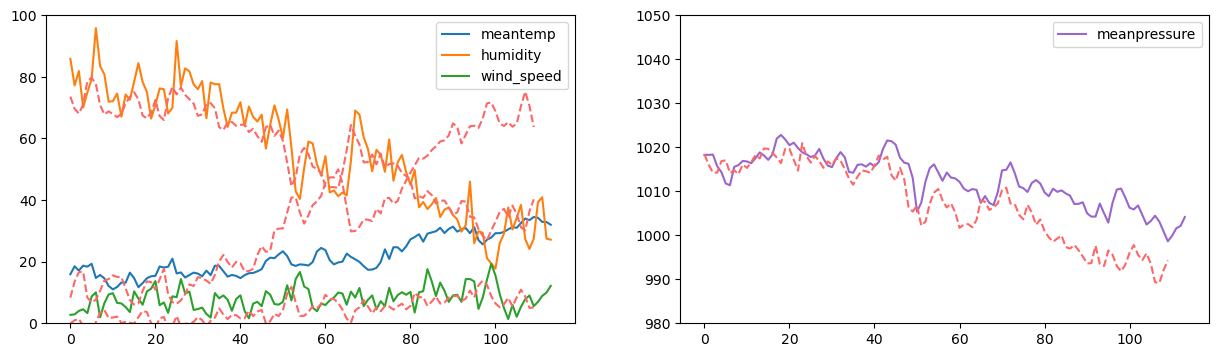

In [73]:
plt.figure(figsize=(15, 4))
plt.subplot(1,2,1)
plt.plot(test1, label="meantemp")
plt.plot(test2, label="humidity")
plt.plot(test3, label="wind_speed")

# plt.subplot(1,2,2)
plt.ylim(0, 100)
plt.plot(result1, color="#FF6666", linestyle="--")
plt.legend()

# plt.subplot(1,2,1)
plt.subplot(1,2,2)
plt.plot(test4, label="meanpressure", color="#9966CC")
plt.ylim(980, 1050)
plt.plot(result2, color="#FF6666", linestyle='--')

plt.legend()